In [2]:
##### import stuff we need!
import pandas as pd
import re
## https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
## its maybe better to use TfidVectorizer than PCA for text? https://stackoverflow.com/questions/34725726/is-it-possible-apply-pca-on-any-text-classification
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


In [ ]:
# Load the dataset
recipes_path = "./data/recipes.json"
recipes_df = pd.read_json(recipes_path)

# main ingredients based on quick excel analysis
ingredients_list = [
    "almond butter", "almonds", "anchovies", "apples", "apricots", "artichoke", "avocados", "bacon",
    "bananas", "basil", "bay leaves", "beans", "beef", "bell pepper", "berry", "blackberries", "bread",
    "broccoli", "broth", "butter", "cabbage", "capers", "caramel", "carrots", "cashews", "chicken", "chickpeas",
    "chili", "chive", "chocolate", "cilantro", "clams", "cocoa", "coconut", "corn", "cornstarch", "crab", "cranberries",
    "cucumber", "dill", "eggplant", "eggs", "fennel", "figs", "fish", "flaxseed", "flour", "frosting", "garlic", "ginger",
    "gnocchi", "green beans", "ham", "herring", "honey", "hot sauce", "jalapeños", "kale", "ketchup", "kimchi", "salt",
    "lamb", "leek", "lemon", "lettuce", "limes", "macaroni", "maple syrup", "mayonnaise", "milk", "mushrooms", "mustard",
    "noodles", "oats", "olive", "olive oil", "onion", "parsley", "peanut butter", "pears", "peas", "pickles", "pineapple",
    "pineapple juice", "pork", "potato", "pumpkin", "quinoa", "red pepper flakes", "rice", "rosemary", "sage", "salmon",
    "salsa", "sardines", "sausage", "scallions", "scallops", "seafood", "sesame oil", "sesame seeds", "shrimp", "snapper",
    "soy sauce", "spaghetti", "spices", "spinach", "squash", "strawberry", "sugar", "sweet potatoes", "swordfish", "tahini",
    "tilapia", "tofu", "tomato", "trout", "tuna", "turkey", "vinegar", "wine", "yams", "yogurt", "zucchini", "oyster sauce",
    "pomegranate"
]

# clean ingredient names 
recipes_df['ingredients'] = recipes_df['ingredients'].apply(lambda x: [ingredient.strip().lower() for ingredient in x])

# make ingredients matrix df
#start with all zeros
ingredient_df = pd.DataFrame(0, index=recipes_df.index, columns=ingredients_list)
ingredient_df['id'] = recipes_df['id']

def match_ingredients(recipe_idx, recipe_ingredients, ingredient_columns):
    for ingredient in recipe_ingredients:
        # Split compound ingredients by common delimiters (like 'and' or 'and', 'with', etc.)
        compound_ingredients = re.split(r'\band\b|\bwith\b|\b,|\b;', ingredient)  
        for sub_ingredient in compound_ingredients:
            sub_ingredient = sub_ingredient.strip()  # Clean up any leading/trailing spaces
            for column in ingredient_columns:
                # Check if this sub-ingredient exactly matches any item in the ingredient list
                if re.search(r'\b' + re.escape(column) + r'\b', sub_ingredient):
                    ingredient_df.loc[recipe_idx, column] = 1
                    break  # Move on after marking the ingredient

# Iterate through the recipes and assign 1s for each ingredient present (with partial matching)
for idx, row in recipes_df.iterrows():
    match_ingredients(idx, row['ingredients'], ingredient_df.columns)

ingredient_df['num_ingredients'] = ingredient_df.iloc[:, :-1].sum(axis=1)  # Sum all columns except the 'id' column
# Drop rows where 'num_ingredients' is 2 or fewer
ingredient_df = ingredient_df[ingredient_df['num_ingredients'] > 2]

# Export the CSV of the matrix so we can look at it and confirm it worked
ingredient_df.to_csv('binary_ingredients_matrix.csv', index=False)



In [19]:

# convert ingredients column to a string
recipes_df['ingredients_string'] = recipes_df['ingredients'].apply(lambda x: ' '.join(x))

# use TfidfVectorizer to figure out which ingredients are the most important across all the recipes
# essentially it gives a weight to each ingredient so that later when we look at it it can decide if that ingredient should be taken into consideration for classification
# https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000) ## to ignore words like is https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
X = vectorizer.fit_transform(recipes_df['ingredients_string'])

# k-clustering
n_clusters = 5  
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
recipes_df['cuisine'] = kmeans.fit_predict(X)

# change numbers to letters -- for no reason other than later I will give them names rather than numbers so i want them to be strings
unique_labels = [chr(i) for i in range(65, 65 + n_clusters)]  
recipes_df['cuisine'] = recipes_df['cuisine'].map(lambda x: unique_labels[x])

In [24]:
def find_matching_recipe(input_ingredients, ingredient_df, recipes_df, assigned_cluster):
    """
    Find a recipe in the assigned cluster that contains all of the input ingredients and return its ID(s).
    
    Parameters:
    - input_ingredients: List of ingredients the user has
    - ingredient_df: Binary ingredient matrix DataFrame
    - recipes_df: Original recipes DataFrame with 'cuisine' column
    - assigned_cluster: Manually assigned cluster (e.g., 'A', 'B', 'C', etc.)
    
    Returns:
    - Recipe ID(s) of the matching recipe(s)
    """
    # Clean the input ingredients (lowercase and stripped of spaces)
    input_ingredients = [ingredient.strip().lower() for ingredient in input_ingredients]
    print(f"Input ingredients: {input_ingredients}")
    
    # Get all recipes from the manually assigned cluster
    recipes_in_cluster = recipes_df[recipes_df['cuisine'] == assigned_cluster]
    print(f"Number of recipes in Cluster {assigned_cluster}: {len(recipes_in_cluster)}")
    
    # Create a binary matrix for the recipes in the assigned cluster
    cluster_ingredient_matrix = ingredient_df[ingredient_df['id'].isin(recipes_in_cluster['id'])]
    
    matching_recipes = []
    for idx, row in cluster_ingredient_matrix.iterrows():
        recipe_id = int(row['id'])
        
        # Get the ingredients that are present in this recipe (where the value is 1)
        recipe_ingredients = row.index[row == 1].tolist()
        
        # Check if all input ingredients are present in the recipe's ingredients
        if all(ingredient in recipe_ingredients for ingredient in input_ingredients):
            matching_recipes.append(recipe_id)
        
        # Debugging output to check the ingredients being considered
        print(f"Checking recipe ID {recipe_id} with ingredients: {recipe_ingredients}")
    
    return matching_recipes if matching_recipes else None  # Return list of recipe IDs (or None if no match)

# Example usage:
input_ingredients = ["flour", "cheese","wine"]  # Example ingredients provided by the user
assigned_cluster = 'A'  # Manually assign this recipe to cluster 'A'

matching_recipe_ids = find_matching_recipe(input_ingredients, ingredient_df, recipes_df, assigned_cluster)

if matching_recipe_ids:
    print(f"Matching recipe ID(s) for Cluster {assigned_cluster}: {matching_recipe_ids}")
else:
    print(f"No recipe found in Cluster {assigned_cluster} that contains all the ingredients.")


Input ingredients: ['flour', 'cheese', 'wine']
Number of recipes in Cluster A: 1926
Checking recipe ID 18009 with ingredients: ['eggs', 'flour', 'milk', 'sugar']
Checking recipe ID 28583 with ingredients: ['bananas', 'corn', 'milk', 'sugar']
Checking recipe ID 38527 with ingredients: ['butter', 'corn', 'flour', 'salt', 'lemon', 'sugar']
Checking recipe ID 22659 with ingredients: ['butter', 'cherries', 'eggs', 'flour', 'sugar']
Checking recipe ID 20827 with ingredients: ['eggs', 'flour', 'salt', 'sugar']
Checking recipe ID 23196 with ingredients: ['bread', 'cheese', 'eggs', 'honey', 'salt', 'milk', 'sugar']
Checking recipe ID 35387 with ingredients: ['bananas', 'chocolate', 'pineapple']
Checking recipe ID 16526 with ingredients: ['chicken', 'eggs', 'flour', 'salt']
Checking recipe ID 26743 with ingredients: ['butter', 'cheese', 'eggs', 'flour', 'salt', 'wine']
Checking recipe ID 10649 with ingredients: ['beef', 'bread', 'butter', 'chili', 'eggs', 'flour', 'salt']
Checking recipe ID 2619

In [30]:
import re

def find_matching_recipe(input_ingredients, ingredient_df, recipes_df, assigned_cluster):
    """
    Find a recipe in the assigned cluster that contains all of the input ingredients (with partial matching)
    and return its ID(s).
    
    Parameters:
    - input_ingredients: List of ingredients the user has
    - ingredient_df: Binary ingredient matrix DataFrame
    - recipes_df: Original recipes DataFrame with 'cuisine' column
    - assigned_cluster: Manually assigned cluster (e.g., 'A', 'B', 'C', etc.)
    
    Returns:
    - Recipe ID(s) of the matching recipe(s)
    """
    # Clean the input ingredients (lowercase and stripped of spaces)
    input_ingredients = [ingredient.strip().lower() for ingredient in input_ingredients]
    print(f"Input ingredients: {input_ingredients}")
    
    # Get all recipes from the manually assigned cluster
    recipes_in_cluster = recipes_df[recipes_df['cuisine'] == assigned_cluster]
    print(f"Number of recipes in Cluster {assigned_cluster}: {len(recipes_in_cluster)}")
    
    # Create a binary matrix for the recipes in the assigned cluster
    cluster_ingredient_matrix = ingredient_df[ingredient_df['id'].isin(recipes_in_cluster['id'])]
    
    matching_recipes = []

    for idx, row in cluster_ingredient_matrix.iterrows():
        recipe_id = int(row['id'])
        
        # Get the ingredients that are present in this recipe (where the value is 1)
        recipe_ingredients = row.index[row == 1].tolist()

        # Check if all input ingredients are partially matched in the recipe
        all_ingredients_matched = True
        for ingredient in input_ingredients:
            # Split compound ingredients by common delimiters (like 'and', 'with', etc.)
            compound_ingredients = re.split(r'\band\b|\bwith\b|\b,|\b;', ingredient)
            matched = False
            for sub_ingredient in compound_ingredients:
                sub_ingredient = sub_ingredient.strip()  # Clean up any leading/trailing spaces
                if check_partial_match(sub_ingredient, recipe_ingredients):
                    matched = True
                    break  # Move on to the next input ingredient once a match is found
            if not matched:
                all_ingredients_matched = False
                break  # Exit the loop if any ingredient doesn't match

        if all_ingredients_matched:
            matching_recipes.append(recipe_id)
        
        # Debugging output to check the ingredients being considered
        print(f"Checking recipe ID {recipe_id} with ingredients: {recipe_ingredients}")
    
    return matching_recipes if matching_recipes else None  # Return list of recipe IDs (or None if no match)


def check_partial_match(sub_ingredient, recipe_ingredients):
    """
    Check if the sub-ingredient (part of an ingredient) matches any ingredient in the recipe.
    This function allows partial matches where the sub-ingredient is contained within a recipe ingredient.
    """
    for recipe_ingredient in recipe_ingredients:
        # Perform substring match to see if the sub_ingredient is part of recipe_ingredient
        if sub_ingredient in recipe_ingredient.lower():  # Ensure case-insensitivity
            return True
    return False


# Example usage:
input_ingredients = ["almond flour", "cheese", "wine"]  # Example ingredients provided by the user
assigned_cluster = 'A'  # Manually assign this recipe to cluster 'A'

matching_recipe_ids = find_matching_recipe(input_ingredients, ingredient_df, recipes_df, assigned_cluster)

if matching_recipe_ids:
    print(f"Matching recipe ID(s) for Cluster {assigned_cluster}: {matching_recipe_ids}")
else:
    print(f"No recipe found in Cluster {assigned_cluster} that contains all the ingredients.")


Input ingredients: ['almond flour', 'cheese', 'wine']
Number of recipes in Cluster A: 1926
Checking recipe ID 18009 with ingredients: ['eggs', 'flour', 'milk', 'sugar']
Checking recipe ID 28583 with ingredients: ['bananas', 'corn', 'milk', 'sugar']
Checking recipe ID 38527 with ingredients: ['butter', 'corn', 'flour', 'salt', 'lemon', 'sugar']
Checking recipe ID 22659 with ingredients: ['butter', 'cherries', 'eggs', 'flour', 'sugar']
Checking recipe ID 20827 with ingredients: ['eggs', 'flour', 'salt', 'sugar']
Checking recipe ID 23196 with ingredients: ['bread', 'cheese', 'eggs', 'honey', 'salt', 'milk', 'sugar']
Checking recipe ID 35387 with ingredients: ['bananas', 'chocolate', 'pineapple']
Checking recipe ID 16526 with ingredients: ['chicken', 'eggs', 'flour', 'salt']
Checking recipe ID 26743 with ingredients: ['butter', 'cheese', 'eggs', 'flour', 'salt', 'wine']
Checking recipe ID 10649 with ingredients: ['beef', 'bread', 'butter', 'chili', 'eggs', 'flour', 'salt']
Checking recipe 

In [ ]:
## go through each cluster and information on ingredients in those clusters 
# one way is to see which ingredient usually exists if one doesnt 
# second way is to look at nutritional value of item and replace it with

#Matching recipe ID(s) for Cluster A: [26743, 14174, 25679, 45051, 526]

## all below is from chatgpt do not use

Index(['id', 'ingredients', 'ingredients_string', 'cuisine'], dtype='object')


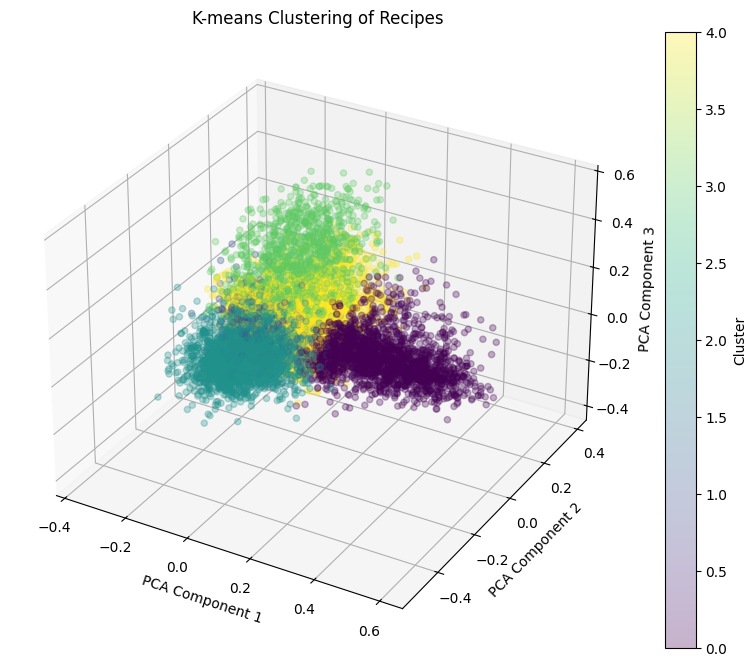

In [6]:
print(recipes_df.columns)

# PCA
pca = PCA(n_components=3) 
X_pca = pca.fit_transform(X.toarray()) 

# plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x = X_pca[:, 0]
y = X_pca[:, 1]
z = X_pca[:, 2]

scatter = ax.scatter(x, y, z, c=recipes_df['cuisine'].map({label: i for i, label in enumerate(unique_labels)}),
                     cmap='viridis', marker='o', alpha=0.3)

ax.set_title("K-means Clustering of Recipes")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")


plt.colorbar(scatter, label='Cluster')
plt.show()

# Save csv to look at it
recipes_df.to_csv('recipes_with_clusters.csv', index=False)

In [7]:
# Get the indices of the most important features for each component (top 5 features per component)
import numpy as np

top_n = 5  # Get top 5 features for each component
for i in range(pca.components_.shape[0]):  # Iterate over each principal component
    component = pca.components_[i]
    top_features_idx = np.argsort(np.abs(component))[-top_n:]  # Get indices of top features
    print(f"Top {top_n} features for PCA component {i+1}:")
    for idx in top_features_idx:
        print(f"  {vectorizer.get_feature_names_out()[idx]} (weight: {component[idx]:.3f})")


Top 5 features for PCA component 1:
  eggs (weight: 0.203)
  purpose (weight: 0.209)
  pepper (weight: -0.224)
  flour (weight: 0.254)
  sugar (weight: 0.260)
Top 5 features for PCA component 2:
  rice (weight: -0.195)
  sesame (weight: -0.253)
  soy (weight: -0.300)
  sauce (weight: -0.335)
  cheese (weight: 0.340)
Top 5 features for PCA component 3:
  lemon (weight: -0.213)
  cream (weight: 0.217)
  shredded (weight: 0.225)
  fresh (weight: -0.229)
  cheese (weight: 0.306)
